#Welcome to BEHAV3D:
##Run all the following cells to run the "organoids death dynamics" analysis

install python dependencies

In [ ]:
!pip install rpy2==3.5.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp310-cp310-linux_x86_64.whl size=318078 sha256=004e2777483ddb6dc595df95daa556550284d088024b74bc88a88e4c5d079ebc
  Stored in directory: /root/.cache/pip/wheels/73/a6/ff/4e75dd1ce1cfa2b9a670cbccf6a1e41c553199e9b25f05d953
Successfully built rpy2
  Attempting uninstall: rpy2
    Found existing installation: rpy2 3.5.5
    Uninstalling rpy2-3.5.5:
      Successfully uninstalled rpy2-3.5.5


In [ ]:
%load_ext rpy2.ipython

# What type of files does BEHAV3D accept?
- You need to upload as many files ending with "_Statistics" with the unique ID or name as number of datasets you want to compare.
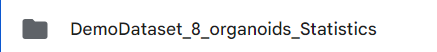
- Inside each folder uploaded you at least need to have the following statistics in a ".csv" format as shown in the following image:
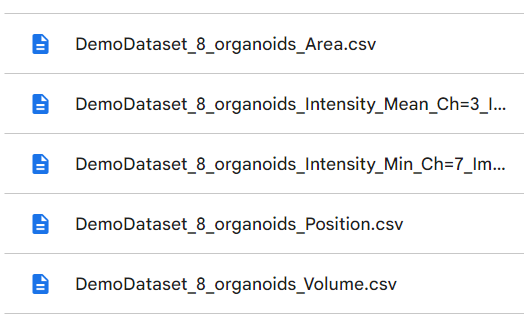

#1) Installing packages
#####(necesary step, takes approximately 20 minutes)

In [ ]:
%%R
install.packages('IRkernel')
install.packages('plyr')
install.packages('readr')
install.packages('dplyr')
install.packages('yaml')
install.packages('optparse')
install.packages('ggplot2')
install.packages("plotly")
install.packages("googledrive")
install.packages("IRdisplay")
install.packages("repr")
install.packages("R.utils")
install.packages("devtools")
install.packages("MESS") #this one takes too long "auc"
install.packages("openxlsx")


IRkernel::installspec()
set.seed(1234)
getwd()

library(plyr)
library(readr)
library(dplyr)
library(yaml)
library(optparse)
library(ggplot2)


(as ‘lib’ is unspecified)







	‘/tmp/RtmpW3zEhG/downloaded_packages’

(as ‘lib’ is unspecified)














	‘/tmp/RtmpW3zEhG/downloaded_packages’

(as ‘lib’ is unspecified)







	‘/tmp/RtmpW3zEhG/downloaded_packages’

(as ‘lib’ is unspecified)







	‘/tmp/RtmpW3zEhG/downloaded_packages’

(as ‘lib’ is unspecified)







	‘/tmp/RtmpW3zEhG/downloaded_packages’

(as ‘lib’ is unspecified)














	‘/tmp/RtmpW3zEhG/downloaded_packages’

(as ‘lib’ is unspecified)







	‘/tmp/RtmpW3zEhG/downloaded_packages’

(as ‘lib’ is unspecified)


































	‘/tmp/RtmpW3zEhG/downloaded_packages’

(as ‘lib’ is unspecified)







	‘/tmp/RtmpW3zEhG/downloaded_packages’

(as ‘lib’ is unspecified)







	‘/tmp/RtmpW3zEhG/downloaded_packages’

(as ‘lib’ is unspecified)







	‘/tmp/RtmpW3zEhG/downloaded_packages’

(as ‘lib’ is unspecified)



















	‘/tmp/RtmpW3zEhG/downloaded_packages’

(as ‘lib’ is unspecified)















































#2) Uploading Files
#**¡IMPORTANT!**
#**Where are your files?:**

####PD: Do either "A" or "B", not both.

#####A) FILES ARE IN MY LOCAL COMPUTER: Load the files to Google Colab directly using the Google Colab feature in the image shown below.
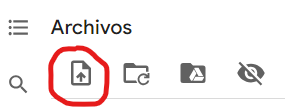



#####B) FILES ARE ON GOOGLE DRIVE: Grant access to the Drive by clicking on the cell bellow.
#####Google Drive Accession:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#3) Location of File in Google Colab



###Regardless from your files original location, your files are now in Google Colab. To the left hand side of your screen you will see your files. Paste on each space provided.

###The following cells must be filled in prior to running the rest of the code:
####-"Data_dir" is the path where you have your data
####-"Output_dir" is the path where you want the output to be stored
####-"Metadata_dir" is the path of the ".tsv" file where the metadata is
####-"folder_name" is the name of the file with all the results at the end of the script

######*PD: The link can be obtained by right clicking the directory/file and clicking on "copy path"*.




In [ ]:
%%R
Data_dir <- "/content/drive/MyDrive/BEHAV3D-main/demos/organoid_demo/data" #@param {type:"string"}
Output_dir <- "/content/drive/MyDrive/BEHAV3D-main/demos/organoid_demo/example_output" #@param {type:"string"}
Metadata_dir <- "/content/drive/MyDrive/BEHAV3D-main/demos/organoid_demo/BEHAV3D_metadata.tsv" #@param {type:"string"}
folder_name <- "My_folder" #@param {type:"string"}


#4) Parameters

In [ ]:
%%R
#@title Parameters to change, if not, they are set to the default values (bars are set to defaul already, only change if you know what you are doing)
organoid_min_volume <- 1000
organoid_min_track_length <- 40
organoid_exp_duration <- 300
organoid_min_volume <- 1000 #@param {type:"slider", min:500, max:1500, step:1}
organoid_min_track_length <- 40 #@param {type:"slider", min:0, max:100, step:1}
organoid_exp_duration <- 300 #@param {type:"slider", min:0, max:500, step:1}
time_interval <- 2 #@param {type:"slider", min:0, max:60, step:1}



#5) Import and Process data


In [ ]:
%%R
'We start by downloading the Metadata file so that we can edit it and stuff'
metadata <- read.csv(Metadata_dir, sep = "\t", header = FALSE)
# Assign headers to the metadata variable
colnames(metadata) <- metadata[1, ]
# Remove the first row (headers)
metadata <- metadata[-1, ]

'Then we search for all the folders under the Data_dir, and check if they end by statistics. If not, we change it'
# Function to search folders recursively and modify basenames
search_and_modify_folders <- function(directory) {
  folder_list <- list.files(directory, recursive = TRUE, full.names = TRUE, include.dirs = TRUE)
  folder_list <- folder_list[file.info(folder_list)$isdir]

  for (i in seq_along(folder_list)) {
    folder_basename <- basename(folder_list[i])
    if (!grepl("_Statistics$", folder_basename)) {
      new_folder_name <- paste0(dirname(folder_list[i]), "/", folder_basename, "_Statistics")
      file.rename(folder_list[i], new_folder_name)
      print(paste("Changed folder name from", folder_basename, "to", basename(new_folder_name)))
    }
  }

  return(list.files(directory, recursive = TRUE, full.names = TRUE, include.dirs = TRUE))
}
# Example
folder_paths <- search_and_modify_folders(Data_dir)

'Then we want the url/Paths for each of the old/new folders under Data_dir, named "_Statistics" now for sure'
# Function to search folders recursively
search_folders <- function(folder_id) {
  # List all items in the folder
  items <- drive_ls(path = as_id(folder_id))$name

  # Filter folders
  folders <- items[grepl("*", items)]

  # Print folders
  return(folders)
  print(folders)
}
# Function to recursively search for folders
search_folders <- function(directory) {
  folder_list <- list.files(directory, recursive = TRUE, full.names = TRUE, include.dirs = TRUE)
  folder_list <- folder_list[file.info(folder_list)$isdir]
  return(folder_list)
}
# Example
folder_paths <- search_folders(Data_dir)

print(folder_paths)

'Now we want to add to the column "organoid_stats_folder" in metadata, the urls obtained before from the "_Statistics" files'
num_rows <- nrow(metadata)
num_cols <- ncol(folder_paths)
metadata <- cbind(metadata, folder_paths)
metadata$organoid_stats_folder <- metadata$folder_paths
metadata$folder_paths <- sub(".*/", "", metadata$folder_paths)
metadata$folder_paths <- sub("_[^_]*$", "", metadata$folder_paths)
metadata$basename <- metadata$folder_paths
metadata <- metadata[, !(colnames(metadata) == "folder_paths")]

'We want to download all the ".csv" files under each folder ended with "_Statistics" and give them a propper name'
# Function to read CSV files and modify folder paths
read_ims_csv <- function(folder_path, pattern) {
  read_plus <- function(flnm, stat_folder) {
    read_csv(flnm, skip = 3, col_types = cols(TrackID = col_character())) %>%
      mutate(filename = flnm, stat_folder = stat_folder)
  }

  # List all CSV files matching the pattern within the folder path
  pattern_files <- list.files(path = folder_path, pattern = pattern, full.names = TRUE)

  if (length(pattern_files) == 0) {
    print(paste("No file with pattern '", pattern, "' found for", folder_path))
    return(NULL)
  }

  # Read and process each CSV file
  ims_csv_list <- lapply(pattern_files, function(flnm) {
    read_plus(flnm, folder_path)
  })

  # Combine the resulting data frames
  ims_csv <- bind_rows(ims_csv_list)

  return(ims_csv)
}

# Recursive function to search folders and read CSV files
recursive_read_ims_csv <- function(directory, pattern) {
  # List all folders within the directory
  folder_list <- list.dirs(directory, recursive = FALSE, full.names = TRUE)

  # Read and process CSV files in each folder
  ims_csv_list <- lapply(folder_list, function(folder_path) {
    read_ims_csv(folder_path, pattern)
  })

  # Combine the resulting data frames
  volume_csv <- bind_rows(ims_csv_list)

  return(volume_csv)
}


stat_folders <- metadata[c("basename", "organoid_stats_folder")]
colnames(stat_folders) <- c("basename", "stats_folder")

# Specify the pattern and the starting directory (Data_dir)
pattern <- "Volume"
volume_csv <- recursive_read_ims_csv(Data_dir, pattern)

# import area
pattern = "Area"
area_csv <- recursive_read_ims_csv(Data_dir, pattern)

# import position
pattern = "Position"
pos_csv <- recursive_read_ims_csv(Data_dir, pattern)

# Import sum_red
sum_red_csv <- NULL
for (i in 1:length(stat_folders$stats_folder)) {
  pat <- paste0("Intensity_Mean_Ch=", metadata$dead_dye_channel[i], "_Img=1")
  img_csv <- read_ims_csv(stat_folders$stats_folder[i], pattern = pat)
  if (!is.null(img_csv)) {
    sum_red_csv <- rbind(sum_red_csv, img_csv)
  }
}


live_deadROI <- cbind(volume_csv[,c("Volume","Time", "TrackID", "ID")],
                      sum_red_csv[,c("Intensity Mean")],
                      area_csv[,c("Area")],
                      pos_csv[,c("Position X","Position Y","Position Z","filename", "stat_folder")])
colnames(live_deadROI) <- c("Volume","Time","TrackID","ID","dead_dye_mean","area", "pos_x","pos_y","pos_z", "filename", "organoid_stats_folder")

### Join the information of metadata to master:
live_deadROI<-left_join(live_deadROI, metadata)

#

### Make TrackID unique for each file:
category <- as.factor(live_deadROI$basename)
ranks <- rank(-table(category), ties.method="first")
ranks <- as.data.frame(ranks)
ranks$basename <- row.names(ranks)
live_deadROI <- left_join(live_deadROI, ranks)  ## plot with all the tracks together
live_deadROI$TrackID2 <- factor(paste(live_deadROI$ranks, live_deadROI$TrackID, sep="_"))

live_deadROI$Original_TrackID <- live_deadROI$TrackID
live_deadROI$TrackID<-live_deadROI$TrackID2
live_deadROI$TrackID2<-NULL

# Check if the "plyr" package is attached
if ("plyr" %in% search()) {
  # Attempt to detach the "plyr" package
  tryCatch(detach(package:plyr, unload = TRUE),
           error = function(e) {
             # Handle the case when detaching fails
             message("Detaching 'plyr' package failed:", conditionMessage(e))
           },
           finally = {
             # Check if the "plyr" package is still attached
             if ("plyr" %in% search()) {
               message("Detaching 'plyr' package failed: Package still attached")
             } else {
               message("Successfully detached 'plyr' package")
             }
           })
} else {
  message("The 'plyr' package is not currently attached")
}
library(dplyr)

### Some organoids fall apart into separated segments, combine them and calculate total dead dye signal
live_deadROI$dead_dye_sum <- live_deadROI$dead_dye_mean*live_deadROI$Volume
live_deadROI1 <-live_deadROI %>%
  group_by(TrackID, Time, organoid_line, tcell_line,exp_nr, well, date) %>%
  summarise(Volume = sum(Volume), dead_dye_sum= sum(dead_dye_sum), area=sum(area), pos_x=mean(pos_x), pos_y=mean(pos_y), pos_z=mean(pos_z))

live_deadROI3 <- live_deadROI1 ## plot with all the tracks together

live_deadROI3$dead_dye_mean <- live_deadROI3$dead_dye_sum/live_deadROI3$Volume
live_deadROI3 <- live_deadROI3[complete.cases(live_deadROI3), ]

### Set time in hours
live_deadROI3$Time2<-(live_deadROI3$Time-1)/time_interval


### Quantify the dead cell dye intensity per well
### Filter organoids with at least pars$organoid_min_track_length timepoints
live_deadROI32<-live_deadROI3%>%
  group_by(TrackID) %>%arrange(TrackID)%>% filter(n() > organoid_min_track_length)

### Combine all the dead cell dye signal from a well
live_deadROI7 <-live_deadROI32 %>%
  group_by(Time, Time2, organoid_line, tcell_line,exp_nr, well, date) %>%
  summarise(Volume = sum(Volume), dead_dye_sum= sum(dead_dye_sum))
live_deadROI7$dead_dye_mean<-live_deadROI7$dead_dye_sum/live_deadROI7$Volume



[1] "/content/drive/MyDrive/BEHAV3D-main/demos/organoid_demo/data/DemoDataset_8_organoids_Statistics"
New names:
• `` -> `...7`
New names:
• `` -> `...7`
New names:
• `` -> `...10`
New names:
• `` -> `...9`
Joining with `by = join_by(organoid_stats_folder)`
Joining with `by = join_by(basename)`


`summarise()` has grouped output by 'TrackID', 'Time', 'organoid_line',
'tcell_line', 'exp_nr', 'well'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'Time', 'Time2', 'organoid_line',
'tcell_line', 'exp_nr', 'well'. You can override using the `.groups` argument.


#Plots

`geom_smooth()` using formula = 'y ~ x'


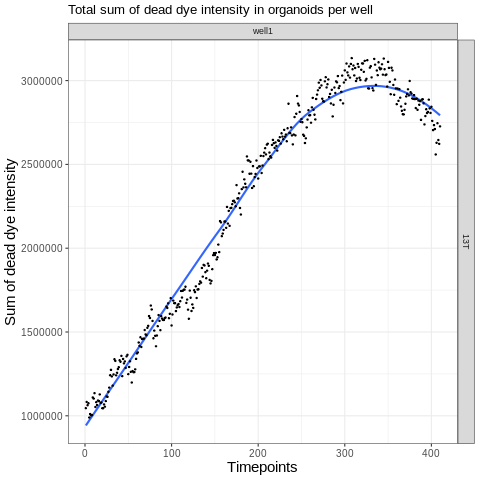

In [ ]:
%%R

ggplot(live_deadROI7, aes(Time,dead_dye_sum)) +
  geom_smooth(method="loess", size = 1, se=F, span=1) +
  geom_point(size=0.5) +
  theme_bw() +
  ylab("Sum of dead dye intensity") +
  xlab("Timepoints") +
  theme(axis.text.x = element_text(size=10), axis.text.y = element_text(size=10), axis.title.y = element_text(size = 15), axis.title.x = element_text(size = 15), legend.text=element_text(size= 10))+
  labs(color = "Organoid")+
  facet_grid(organoid_line~well, scales = "free")+
  ggtitle("Total sum of dead dye intensity in organoids per well")


Saving 6.67 x 6.67 in image
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


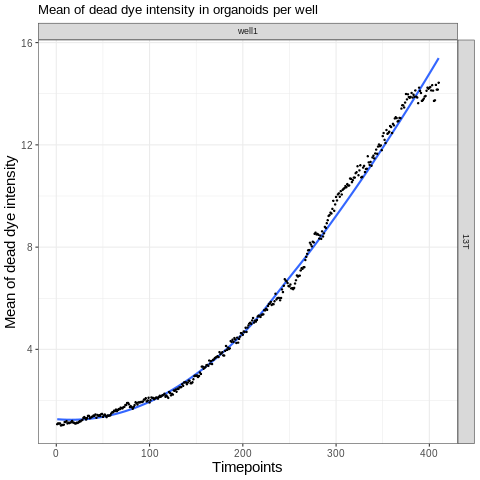

In [ ]:
%%R
library(ggplot2)

plot1 <- ggplot(live_deadROI7, aes(Time, dead_dye_mean)) +
  geom_smooth(method = "loess", size = 1, se = FALSE, span = 1) +
  geom_point(size = 0.5) +
  theme_bw() +
  ylab("Mean of dead dye intensity") +
  xlab("Timepoints") +
  theme(axis.text.x = element_text(size = 10),
        axis.text.y = element_text(size = 10),
        axis.title.y = element_text(size = 15),
        axis.title.x = element_text(size = 15),
        legend.text = element_text(size = 10)) +
  labs(color = "Organoid") +
  facet_grid(organoid_line ~ well, scales = "free") +
  ggtitle("Mean of dead dye intensity in organoids per well")

#NOW I NEED TO SAVE THIS GRAPH

library(googledrive)
# Set the file names
pdf_filename <- "Full_well_death_dynamics.pdf"
rds_filename <- "Full_well_death_dynamics.rds"

# Save the PDF and RDS files locally
pdf_file <- file.path(getwd(), pdf_filename)
rds_file <- file.path(getwd(), rds_filename)

ggsave(pdf_file, device = "pdf")  # Save the PDF in the local directory
saveRDS(live_deadROI7, file = rds_file)  # Save the RDS file in the local directory


# Set the destination file path
destination_file <- file.path(Output_dir, "Full_well_death_dynamics.pdf")
# Copy the file to the destination path
file.copy(pdf_filename, destination_file)

# Set the destination file path
destination_file <- file.path(Output_dir, "Full_well_death_dynamics.rds")
# Copy the file to the destination path
file.copy(rds_filename, destination_file)

print(plot1)

Saving 6.67 x 6.67 in image
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


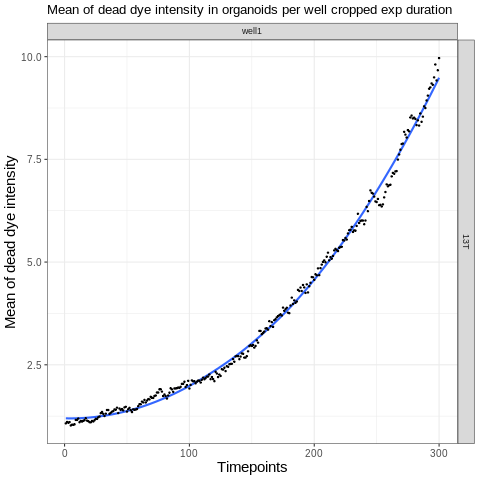

In [ ]:
%%R
live_deadROI7_exp_dur = live_deadROI7[live_deadROI7$Time <= organoid_exp_duration,]

plot2 <- ggplot(live_deadROI7_exp_dur, aes(Time, dead_dye_mean)) +
  geom_smooth(method = "loess", size = 1, se = FALSE, span = 1) +
  geom_point(size = 0.5) +
  theme_bw() +
  ylab("Mean of dead dye intensity") +
  xlab("Timepoints") +
  theme(axis.text.x = element_text(size = 10),
        axis.text.y = element_text(size = 10),
        axis.title.y = element_text(size = 15),
        axis.title.x = element_text(size = 15),
        legend.text = element_text(size = 10)) +
  labs(color = "Organoid") +
  facet_grid(organoid_line ~ well, scales = "free") +
  ggtitle("Mean of dead dye intensity in organoids per well cropped exp duration")
#NOW I NEED TO SAVE THIS GRAPH

library(googledrive)
# Set the file names
pdf_filename <- "Exp_well_death_dynamics.pdf"
rds_filename <- "Exp_well_death_dynamics.rds"

# Save the PDF and RDS files locally
pdf_file <- file.path(getwd(), pdf_filename)
rds_file <- file.path(getwd(), rds_filename)

ggsave(pdf_file, device = "pdf")  # Save the PDF in the local directory
saveRDS(live_deadROI7_exp_dur, file = rds_file)  # Save the RDS file in the local directory


# Set the destination file path
destination_file <- file.path(Output_dir, "Exp_well_death_dynamics.pdf")
# Copy the file to the destination path
file.copy(pdf_filename, destination_file)

# Set the destination file path
destination_file <- file.path(Output_dir, "Exp_well_death_dynamics.rds")
# Copy the file to the destination path
file.copy(rds_filename, destination_file)

print(plot2)


Attaching package: ‘scales’



    col_factor




Joining with `by = join_by(organoid_line, tcell_line, exp_nr, well, date)`
Saving 6.67 x 6.67 in image
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


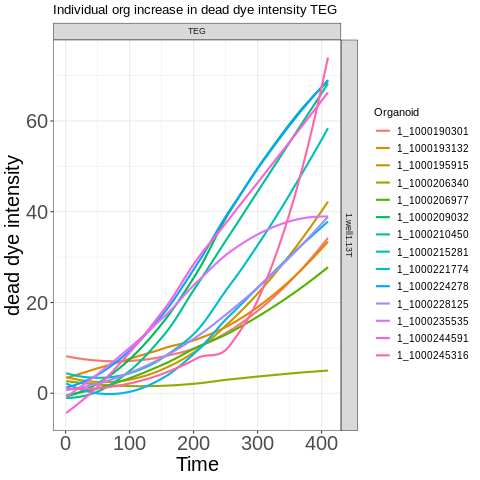

In [ ]:
%%R

### Process the death dynamics per individual organoid
library(scales)
live_deadROI3<-live_deadROI3%>% ungroup()%>%
  mutate(dead_dye_mean_rescaled=rescale(dead_dye_mean, to=c(0,100)))
live_deadROI3<-live_deadROI3%>%
  group_by(TrackID) %>%arrange(TrackID)%>% filter(n() > organoid_min_track_length)
temp1 <- aggregate(dead_dye_mean_rescaled ~ TrackID+organoid_line+tcell_line+exp_nr+well+date, data = live_deadROI3, max)  ##calculate the max red of each track
temp2 <- aggregate(dead_dye_mean ~ TrackID+organoid_line+tcell_line+exp_nr+well+date, data = live_deadROI3, max)
colnames(temp1) [length(names(temp1))] <- "max_dead_dye_mean_rescaled"
colnames(temp2) [length(names(temp1))] <- "max_dead_dye_mean"

temp_merge <-merge(temp1, temp2)

### Filter out organoids that have dead dye signal above 'organoid_dead_dye_threshold' (e.g. dead) and are bigger than 'organoid_min_volume'
live_deadROI4 <- merge(temp_merge, live_deadROI3)

live_deadROI6 <- left_join(live_deadROI4, metadata)
live_deadROI6aliveT0 <-live_deadROI6%>%group_by(TrackID)%>%filter(Time==min(Time) & dead_dye_mean<organoid_dead_dye_threshold & Volume>organoid_min_volume)
live_deadROI6 <-live_deadROI6%>%filter(TrackID %in% live_deadROI6aliveT0$TrackID)


## Filter for the organoids that increase in red dead cell dye, substitute by the max:
library(tibble)  # for `rownames_to_column` and `column_to_rownames`
temp1 <- live_deadROI6%>%rownames_to_column('row') %>%arrange(Time) %>% group_by(TrackID) %>% filter(row_number() <= which.max(dead_dye_mean))%>%column_to_rownames('row')
# Filter the rows that are missing (after reaching the max):
temp2<-subset(live_deadROI6, !row.names(live_deadROI6)%in%row.names(temp1))
temp2$dead_dye_mean_rescaled<-temp2$max_dead_dye_mean_rescaled
live_deadROI6<-rbind(temp1, temp2)

### plot to check outcome
library(ggplot2)

plot3 <- ggplot(live_deadROI6, aes(Time, dead_dye_mean_rescaled, color = TrackID, group = TrackID)) +
  geom_smooth(method = "loess", size = 1, se = FALSE, span = 1) +
  theme_bw() +
  ylab("dead dye intensity") +
  xlab("Time") +
  theme(axis.text.x = element_text(size = 20),
        axis.text.y = element_text(size = 20),
        axis.title.y = element_text(size = 20),
        axis.title.x = element_text(size = 20),
        legend.text = element_text(size = 10)) +
  labs(color = "Organoid") +
  facet_grid(interaction(exp_nr, well, organoid_line) ~ tcell_line, scales = "free") +
  ggtitle("Individual org increase in dead dye intensity TEG")

#NOW I NEED TO SAVE THIS GRAPH

# Set the file names
pdf_filename <- "Full_individual_orgs_death_dynamics.pdf"
rds_filename <- "Full_individual_orgs_death_dynamics.rds"

# Save the PDF and RDS files locally
pdf_file <- file.path(getwd(), pdf_filename)
rds_file <- file.path(getwd(), rds_filename)

ggsave(pdf_file, device = "pdf")  # Save the PDF in the local directory
saveRDS(live_deadROI6, file = rds_file)  # Save the RDS file in the local directory


# Set the destination file path
destination_file <- file.path(Output_dir, "Full_individual_orgs_death_dynamics.pdf")
# Copy the file to the destination path
file.copy(pdf_filename, destination_file)

# Set the destination file path
destination_file <- file.path(Output_dir, "Full_individual_orgs_death_dynamics.rds")
# Copy the file to the destination path
file.copy(rds_filename, destination_file)

print(plot3)


Saving 6.67 x 6.67 in image
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


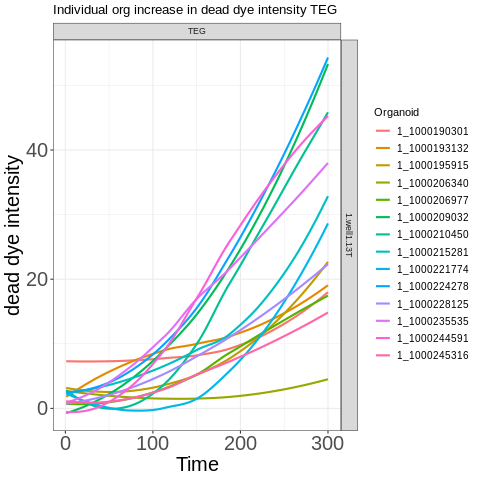

In [ ]:
%%R

live_deadROI6_exp_dur = live_deadROI6[live_deadROI6$Time<=organoid_exp_duration,]
### plot to check outcome
library(ggplot2)

plot4 <- ggplot(live_deadROI6_exp_dur, aes(Time, dead_dye_mean_rescaled, color = TrackID, group = TrackID)) +
  geom_smooth(method = "loess", size = 1, se = FALSE, span = 1) +
  theme_bw() +
  ylab("dead dye intensity") +
  xlab("Time") +
  theme(axis.text.x = element_text(size = 20),
        axis.text.y = element_text(size = 20),
        axis.title.y = element_text(size = 20),
        axis.title.x = element_text(size = 20),
        legend.text = element_text(size = 10)) +
  labs(color = "Organoid") +
  facet_grid(interaction(exp_nr, well, organoid_line) ~ tcell_line, scales = "free") +
  ggtitle("Individual org increase in dead dye intensity TEG")

#NOW I NEED TO SAVE THIS GRAPH
# Set the file names
pdf_filename <- "Exp_individual_orgs_death_dynamics.pdf"
rds_filename <- "Exp_individual_orgs_death_dynamics.rds"

# Save the PDF and RDS files locally
pdf_file <- file.path(getwd(), pdf_filename)
rds_file <- file.path(getwd(), rds_filename)

ggsave(pdf_file, device = "pdf")  # Save the PDF in the local directory
saveRDS(live_deadROI6_exp_dur, file = rds_file)  # Save the RDS file in the local directory


# Set the destination file path
destination_file <- file.path(Output_dir, "Exp_individual_orgs_death_dynamics.pdf")
# Copy the file to the destination path
file.copy(pdf_filename, destination_file)

# Set the destination file path
destination_file <- file.path(Output_dir, "Exp_individual_orgs_death_dynamics.rds")
# Copy the file to the destination path
file.copy(rds_filename, destination_file)

print(plot4)

In [ ]:
%%R

library(dplyr)
library(scales)
library(MESS)

##Import dataframe live_deadROI7 for each experiment. Combine several if necessary
Combi<-live_deadROI7

## Rescale the mean dead cell dye per experiment
Combi<-Combi%>%
  group_by(exp_nr) %>%
  mutate(dead_dye_mean_rescaled=rescale(dead_dye_mean, to=c(0,100)))%>%ungroup()
## for each well normalize the dead cell dye mean intensity to timepoint 1
Combi<-Combi%>%group_by( organoid_line,tcell_line , exp_nr , well, date)%>%arrange(Time2)%>%mutate(dead_dye_mean_norm=dead_dye_mean_rescaled - first(dead_dye_mean_rescaled))%>%filter(Time<organoid_exp_duration)

## calculate area under the curve for each donor/T cell co-culture
Area_under_Curve<-Combi%>%
  group_by( organoid_line,tcell_line , exp_nr , well, date)%>%summarise(auc=auc(Time2,dead_dye_mean_norm))%>%ungroup()
## calculate delta increase for each donor/T cell co-culture
delta <-Combi%>%group_by( organoid_line,tcell_line , exp_nr , well, date)%>%arrange(Time2)%>%summarize(delta= last(dead_dye_mean_norm) - first(dead_dye_mean_norm))%>%ungroup()
## combine both delta and AUC in one dataframe
AUC_delta<-left_join(Area_under_Curve,delta,by=c("organoid_line" ,"tcell_line" ,"exp_nr"  , "well" , "date"  ))


library(openxlsx)

#Uploading the "AUC_delta.xlsx" file to drive
write.xlsx(AUC_delta, "AUC_delta.xlsx")
# Set the source file path
source_file <- "AUC_delta.xlsx"
# Set the destination file path
destination_file <- file.path(Output_dir, "AUC_delta.xlsx")
# Copy the file to the destination path
file.copy(source_file, destination_file)


`summarise()` has grouped output by 'organoid_line', 'tcell_line', 'exp_nr',
'well'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'organoid_line', 'tcell_line', 'exp_nr',
'well'. You can override using the `.groups` argument.
[1] TRUE


`summarise()` has grouped output by 'organoid_line', 'tcell_line', 'exp_nr',
'well'. You can override using the `.groups` argument.
Joining with `by = join_by(organoid_line, tcell_line, exp_nr, well, date)`
`summarise()` has grouped output by 'Time', 'organoid_line', 'tcell_line',
'exp_nr', 'well'. You can override using the `.groups` argument.
Saving 6.67 x 6.67 in image


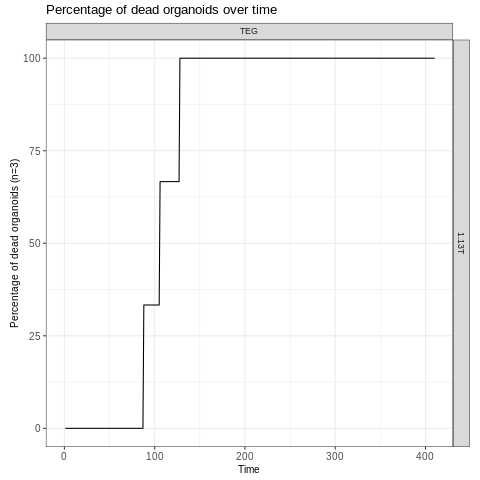

In [ ]:
%%R

live_deadROI6$dead<-ifelse(live_deadROI6$dead_dye_mean<live_deadROI6$organoid_dead_dye_threshold,0,1)
library(tidyr)
### fill missing values with NA
live_deadROI6<-live_deadROI6 %>%group_by(organoid_line, tcell_line,exp_nr, well, date)%>%arrange(Time, .by_group = TRUE)%>% complete(Time, nesting(TrackID))
## refill NA with previous value
live_deadROI6<-live_deadROI6 %>%group_by(organoid_line, tcell_line,exp_nr, well, date)%>%arrange(Time, .by_group = TRUE)%>%fill(names(live_deadROI6))
## select the dead cells
live_deadROI4_dead <-live_deadROI6%>%group_by(organoid_line, tcell_line,exp_nr, well, date, TrackID)%>%filter(max_dead_dye_mean>organoid_dead_dye_threshold )
# live_deadROI4_dead$track_exp <- with(live_deadROI4_dead , interaction(TrackID,Time))
live_deadROI4_live <-live_deadROI6%>%group_by(TrackID, organoid_line, tcell_line,exp_nr, well, date)%>%filter(max_dead_dye_mean<=organoid_dead_dye_threshold ) ## select the live cells
temp2 <-live_deadROI4_dead%>%group_by(TrackID, organoid_line, tcell_line,exp_nr, well, date)## group by track ID
temp2 <- temp2%>%arrange(Time, .by_group = TRUE)
### After timepoint of dying set further timepoints to dead=1 as well
live_deadROI5_dead <- temp2 %>% group_by(TrackID, organoid_line, tcell_line,exp_nr, well, date) %>% filter(row_number() >= which.max(dead)) ## stop at max dead
live_deadROI6 <- temp2 %>% group_by(TrackID, organoid_line, tcell_line,exp_nr, well, date) %>% mutate(dead=replace(dead, row_number() > which.max(dead), 1))
live_deadROI6 <- live_deadROI6 %>% group_by(TrackID, organoid_line, tcell_line,exp_nr, well, date) %>% arrange(Time, .by_group = TRUE) %>% mutate(dead=replace(dead, row_number() > which.max(dead), 1))


# test1 <- live_deadROI4_dead%>%filter(!track_exp%in% live_deadROI5_dead$track_exp)  ###find all the rows that are beyond max red
# test1$dead<-1 ## set as dead beyond max red
# live_deadROI6_2<-rbind(live_deadROI4_live,live_deadROI5_dead[,c(-16)],test1[,c(-16)])  ## bind dataframe again
## calculate the number of organoids at T0 to calculate the percentage
live_deadROI6_n_t0<-live_deadROI6%>%filter(Time==1)%>%group_by(organoid_line, tcell_line,exp_nr, well, date)%>%summarise(starting_nr_organoids= n())
live_deadROI6_2<-left_join(live_deadROI6,live_deadROI6_n_t0)
live_deadROI6_2$starting_nr_organoids<-as.numeric(live_deadROI6_2$starting_nr_organoids)
# for each dead calculate the percentage of dead cells, if no, then 0
live_deadROI6_per<-live_deadROI6_2%>%group_by(Time, organoid_line, tcell_line,exp_nr, well, date, .drop=FALSE)%>%summarize(n=sum(dead==1), starting_nr_organoids=mean(starting_nr_organoids))%>%mutate(perc = n*100 / starting_nr_organoids)

library(ggplot2)
# live_deadROI6_per$Time<-live_deadROI6_per$Time.x/2
### normalize to the initial number of dead organoids
perc_dead<- live_deadROI6_per%>%
  group_by(organoid_line, tcell_line,exp_nr, well, date)%>%
  arrange(Time)%>%
  mutate(perc_dead_norm=perc - first(perc))

p1 <- ggplot(perc_dead, aes(as.numeric(Time), perc_dead_norm)) +
  geom_line()+
  # geom_smooth(method = "loess",size = 0.5, se = T, alpha=0.3, span=1)+
  theme_bw() +
  ylab(paste0("Percentage of dead organoids (n=", live_deadROI6_n_t0$starting_nr_organoids, ")")) +
  # coord_cartesian(ylim=c(0,100), xlim=c(0,pars$organoid_exp_duration))+
  scale_y_continuous(limit=c(0,100),oob=squish)+
  scale_x_continuous(limit=c(0,max(perc_dead$Time)))+
  xlab("Time") +
  facet_grid(interaction(exp_nr,organoid_line)  ~ tcell_line, scales = "free")+
  theme(axis.text.x = element_text(size=10),
        axis.text.y = element_text(size=10),
        axis.title.y = element_text(size = 10),
        axis.title.x = element_text(size = 10),
        legend.text=element_text(size= 10))+
  ggtitle("Percentage of dead organoids over time")+theme(aspect.ratio=1)


#NOW I NEED TO DOWNLOAD THE PREVIOUS PLOT
# Set the file names
pdf_filename <- "Full_percentage_dead_org_over_time.pdf"
rds_filename <- "Full_percentage_dead_org_over_time.rds"

# Save the PDF and RDS files locally
pdf_file <- file.path(getwd(), pdf_filename)
rds_file <- file.path(getwd(), rds_filename)

ggsave(pdf_file, device = "pdf")  # Save the PDF in the local directory
saveRDS(perc_dead, file = rds_file)  # Save the RDS file in the local directory


# Set the destination file path
destination_file <- file.path(Output_dir, "Full_percentage_dead_org_over_time.pdf")
# Copy the file to the destination path
file.copy(pdf_filename, destination_file)

# Set the destination file path
destination_file <- file.path(Output_dir, "Full_percentage_dead_org_over_time.rds")
# Copy the file to the destination path
file.copy(rds_filename, destination_file)

print(p1)


Saving 6.67 x 6.67 in image


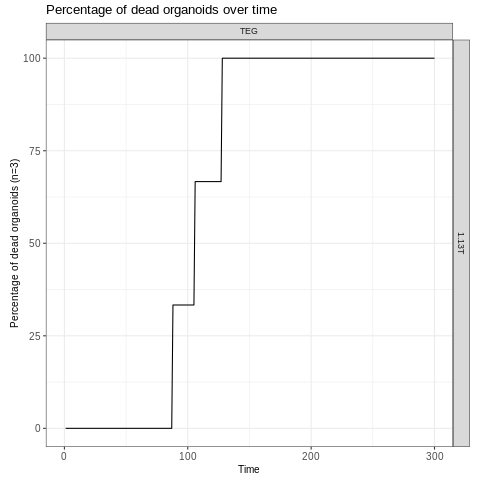

In [ ]:
%%R

perc_dead_exp_dur <- perc_dead %>%
  filter(Time<=organoid_exp_duration)

p2 <- ggplot(perc_dead_exp_dur, aes(as.numeric(Time), perc_dead_norm)) +
  geom_line()+
  # geom_smooth(method = "loess",size = 0.5, se = T, alpha=0.3, span=1)+
  theme_bw() +
  ylab(paste0("Percentage of dead organoids (n=", live_deadROI6_n_t0$starting_nr_organoids, ")")) +
  # coord_cartesian(ylim=c(0,100), xlim=c(0,organoid_exp_duration))+
  scale_y_continuous(limit=c(0,100),oob=squish)+
  scale_x_continuous(limit=c(0,min(max(perc_dead_exp_dur$Time),organoid_exp_duration)))+
  xlab("Time") +
  facet_grid(interaction(exp_nr,organoid_line)  ~ tcell_line, scales = "free")+
  theme(axis.text.x = element_text(size=10),
        axis.text.y = element_text(size=10),
        axis.title.y = element_text(size = 10),
        axis.title.x = element_text(size = 10),
        legend.text=element_text(size= 10))+
  ggtitle("Percentage of dead organoids over time")+theme(aspect.ratio=1)


#NOW I NEED TO DOWNLOAD THE PREVIOUS PLOT
# Set the file names
pdf_filename <- "Exp_percentage_dead_org_over_time.pdf"
rds_filename <- "Exp_percentage_dead_org_over_time.rds"

# Save the PDF and RDS files locally
pdf_file <- file.path(getwd(), pdf_filename)
rds_file <- file.path(getwd(), rds_filename)

ggsave(pdf_file, device = "pdf")  # Save the PDF in the local directory
saveRDS(perc_dead_exp_dur, file = rds_file)  # Save the RDS file in the local directory


# Set the destination file path
destination_file <- file.path(Output_dir, "Exp_percentage_dead_org_over_time.pdf")
# Copy the file to the destination path
file.copy(pdf_filename, destination_file)

# Set the destination file path
destination_file <- file.path(Output_dir, "Exp_percentage_dead_org_over_time.rds")
# Copy the file to the destination path
file.copy(rds_filename, destination_file)


print(p2)


check if saved locally when tried with local files
make in local files to try it out

#6) If you want to download the generated files as a zip to your local computer, do the following:
###1) Run this code
###2) Right click on the generated file named "my_folder.zip" and click on download. Like in the image:
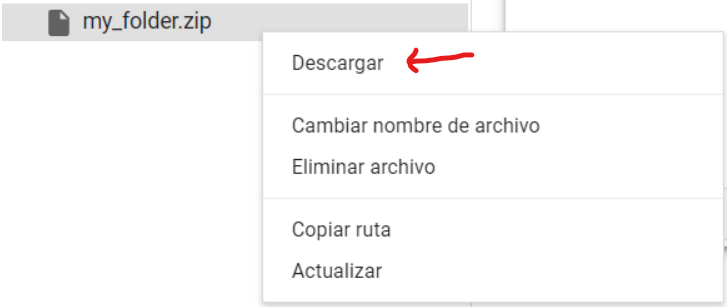

In [ ]:
%%R

#Generating the folder
dir.create(folder_name)

# Get a list of all files in the current directory
file_list <- list.files()

# Exclude files named "drive" or "sample_data"
files_to_move <- file_list[!(file_list %in% c("drive", "sample_data"))]

# Move files to the new folder
for (file in files_to_move) {
  file_path <- file
  new_path <- paste0(folder_name, "/", file)
  file.rename(file_path, new_path)
}

zip_file_path <- paste0(folder_name, ".zip")
zip(zip_file_path, files = list.files(folder_name, recursive = TRUE, full.names = TRUE))


